In [19]:
import cv2
import numpy as np
import random
from scipy.stats import norm
import matplotlib.pyplot as plt

def generate_parallel_light_mask(mask_size,
                                 position=None,
                                 direction=None,
                                 max_brightness=255,
                                 min_brightness=0,
                                 mode="gaussian",
                                 linear_decay_rate=None):

    if position is None:
        pos_x = random.randint(0, mask_size[0])
        pos_y = random.randint(0, mask_size[1])
    else:
        pos_x = position[0]
        pos_y = position[1]
    if direction is None:
        direction = random.randint(0, 360)
        print("Rotate degree: ", direction)
    if linear_decay_rate is None:
        if mode == "linear_static":
            linear_decay_rate = random.uniform(0.2, 2)
        if mode == "linear_dynamic":
            linear_decay_rate = (max_brightness - min_brightness) / max(mask_size)
    assert mode in ["linear_dynamic", "linear_static", "gaussian"], \
        "mode must be linear_dynamic, linear_static or gaussian"
    padding = int(max(mask_size) * np.sqrt(2))
    canvas_x = padding * 2 + mask_size[0]
    canvas_y = padding * 2 + mask_size[1]
    mask = np.zeros(shape=(canvas_y, canvas_x), dtype=np.float32)
    init_mask_ul = (int(padding), int(padding))
    init_mask_br = (int(padding+mask_size[0]), int(padding+mask_size[1]))
    init_light_pos = (padding + pos_x, padding + pos_y)
    
    for i in range(canvas_y):
        if mode == "linear":
            i_value = _decayed_value_in_linear(i, max_brightness, init_light_pos[1], linear_decay_rate)
        elif mode == "gaussian":
            i_value = _decayed_value_in_norm(i, max_brightness, min_brightness, init_light_pos[1], mask_size[1])
        else:
            i_value = 0
        mask[i] = i_value
    # rotate mask
    rotate_M = cv2.getRotationMatrix2D(init_light_pos, direction, 1)
    mask = cv2.warpAffine(mask, rotate_M, (canvas_x,  canvas_y))
    # crop
    mask = mask[init_mask_ul[1]:init_mask_br[1], init_mask_ul[0]:init_mask_br[0]]
    mask = np.asarray(mask, dtype=np.uint8)
    # add median blur
    mask = cv2.medianBlur(mask, 9)
    mask = 255 - mask
    
    return mask

In [20]:
def _decayed_value_in_norm(x, max_value, min_value, center, range):

    radius = range / 3
    center_prob = norm.pdf(center, center, radius)
    x_prob = norm.pdf(x, center, radius)
    x_value = (x_prob / center_prob) * (max_value - min_value) + min_value
    return x_value

In [21]:
def _decayed_value_in_linear(x, max_value, padding_center, decay_rate):

    x_value = max_value - abs(padding_center - x) * decay_rate
    if x_value < 0:
        x_value = 1
    return x_value

In [22]:
def add_parallel_light(image, light_position=None, direction=None, max_brightness=255, min_brightness=0,
                       mode="gaussian", linear_decay_rate=None, transparency=None):
   
    if transparency is None:
        transparency = random.uniform(0.5, 0.85)
    frame = cv2.imread(image)
    height, width, _ = frame.shape
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = generate_parallel_light_mask(mask_size=(width, height),
                                        position=light_position,
                                        direction=direction,
                                        max_brightness=max_brightness,
                                        min_brightness=min_brightness,
                                        mode=mode,
                                        linear_decay_rate=linear_decay_rate)
    hsv[:, :, 2] = hsv[:, :, 2] * transparency + mask * (1 - transparency)
    frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    frame[frame > 255] = 255
    frame = np.asarray(frame, dtype=np.uint8)
    return frame

In [23]:
img = '/home/mehul/Downloads/washing_machine.jpeg'

Rotate degree:  213


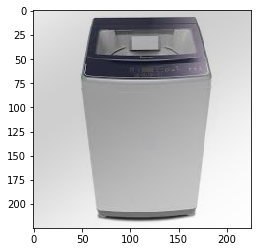

In [24]:
enhanced_image = add_parallel_light(img)
plt.imshow(enhanced_image)
plt.show()

In [25]:
def generate_spot_light_mask(mask_size,
                             position=None,
                             max_brightness=255,
                             min_brightness=0,
                             mode="gaussian",
                             linear_decay_rate=None,
                             speedup=False):

    if position is None:
        position = [(random.randint(0, mask_size[0]), random.randint(0, mask_size[1]))]
    if linear_decay_rate is None:
        if mode == "linear_static":
            linear_decay_rate = random.uniform(0.25, 1)
    assert mode in ["linear", "gaussian"], \
        "mode must be linear_dynamic, linear_static or gaussian"
    mask = np.zeros(shape=(mask_size[1], mask_size[0]), dtype=np.float32)
    if mode == "gaussian":
        mu = np.sqrt(mask.shape[0]**2+mask.shape[1]**2)
        dev = mu / 3.5
        mask = _decay_value_radically_norm_in_matrix(mask_size, position, max_brightness, min_brightness, dev)
    mask = np.asarray(mask, dtype=np.uint8)
    # add median blur
    mask = cv2.medianBlur(mask, 5)
    mask = 255 - mask
    # cv2.imshow("mask", mask)
    # cv2.waitKey(0)
    return mask


In [26]:
def _decay_value_radically_norm_in_matrix(mask_size, centers, max_value, min_value, dev):

    center_prob = norm.pdf(0, 0, dev)
    x_value_rate = np.zeros((mask_size[1], mask_size[0]))
    for center in centers:
        coord_x = np.arange(mask_size[0])
        coord_y = np.arange(mask_size[1])
        xv, yv = np.meshgrid(coord_x, coord_y)
        dist_x = xv - center[0]
        dist_y = yv - center[1]
        dist = np.sqrt(np.power(dist_x, 2) + np.power(dist_y, 2))
        x_value_rate += norm.pdf(dist, 0, dev) / center_prob
    mask = x_value_rate * (max_value - min_value) + min_value
    mask[mask > 255] = 255
    return mask

In [27]:
def _decay_value_radically_norm(x, centers, max_value, min_value, dev):

    center_prob = norm.pdf(0, 0, dev)
    x_value_rate = 0
    for center in centers:
        distance = np.sqrt((center[0]-x[0])**2 + (center[1]-x[1])**2)
        x_value_rate += norm.pdf(distance, 0, dev) / center_prob
    x_value = x_value_rate * (max_value - min_value) + min_value
    x_value = 255 if x_value > 255 else x_value
    return x_value

In [28]:
def add_spot_light(image, light_position=None, max_brightness=255, min_brightness=0,
                   mode='gaussian', linear_decay_rate=None, transparency=None):

    if transparency is None:
        transparency = random.uniform(0.5, 0.85)
    frame = cv2.imread(image)
    height, width, _ = frame.shape
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = generate_spot_light_mask(mask_size=(width, height),
                                    position=light_position,
                                    max_brightness=max_brightness,
                                    min_brightness=min_brightness,
                                    mode=mode,
                                    linear_decay_rate=linear_decay_rate)
    hsv[:, :, 2] = hsv[:, :, 2] * transparency + mask * (1 - transparency)
    frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    frame[frame > 255] = 255
    frame = np.asarray(frame, dtype=np.uint8)
    return frame

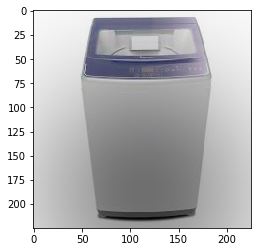

In [29]:
enhanced_image = add_spot_light(img)
plt.imshow(enhanced_image)
plt.show()